In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import sys

カラム検証成功: カラム名と順序が正確に一致しています
C:\Users\tetsu\Documents\energy-env\202505\20250509_power_usage.csv を読み込みました
カラム検証成功: カラム名と順序が正確に一致しています
C:\Users\tetsu\Documents\energy-env\202505\20250508_power_usage.csv を読み込みました
カラム検証成功: カラム名と順序が正確に一致しています
C:\Users\tetsu\Documents\energy-env\202505\20250507_power_usage.csv を読み込みました

Prophet用に整形したデータ:
                   ds         y
0 2025-05-07 00:00:00  20980000
1 2025-05-07 01:00:00  20200000
2 2025-05-07 02:00:00  20290000
3 2025-05-07 03:00:00  20750000
4 2025-05-07 04:00:00  20940000

合計データポイント数: 72


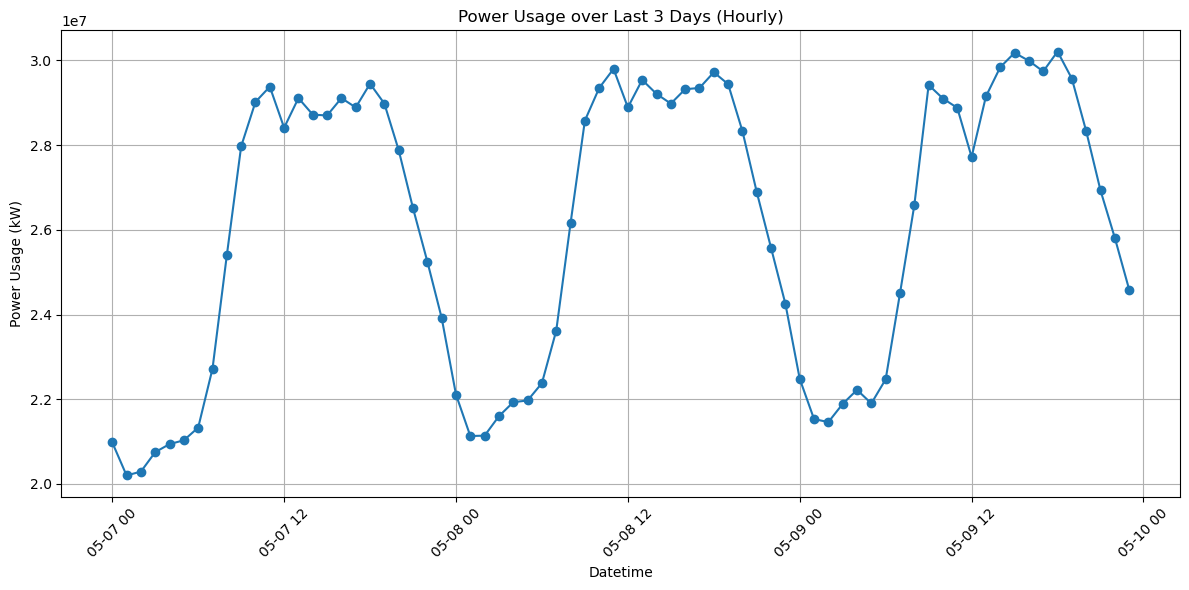

Prophet用データを 'prophet_ready_data_3days.csv' として保存しました


In [6]:
base_dir = r"C:\Users\tetsu\Documents\energy-env"

# 現在の日付を取得
current_date = datetime.now()

# 3日分のデータを取得するための日付リスト作成
date_list = []
for i in range(3):
    target_date = current_date - timedelta(days=i+1)  # 今日を除く3日前まで
    date_list.append(target_date)

# 全てのデータを格納するための空のDataFrame
all_data = pd.DataFrame()

# 全てのデータを格納するための空のDataFrame
all_data = pd.DataFrame()

# 各日付のデータを読み込んで結合
for target_date in date_list:
    year_month = target_date.strftime('%Y%m')  # yyyymm形式
    day = target_date.strftime('%d')  # dd形式
    
    # ファイルパスを構築
    dir_path = os.path.join(base_dir, year_month)
    file_pattern = f"{year_month}{day}_power_usage.csv"
    file_path = os.path.join(dir_path, file_pattern)

     # ファイルが存在するか確認
    if os.path.exists(file_path):
        try:
            # CSVファイルの読み込み（最初の3列だけ読み込む）
            df = pd.read_csv(file_path, encoding='shift_jis', skiprows=13, nrows=24, usecols=[0, 1, 2])

            # 期待するカラム名と順序（厳密に一致する必要がある）
            expected_columns = ['DATE', 'TIME', '当日実績(万kW)']
            actual_columns = df.columns.tolist()

            # カラム名と順序の完全一致チェック
            if actual_columns == expected_columns:
                print(f"カラム検証成功: カラム名と順序が正確に一致しています")
            
                # カラム名を英語に設定
                df.columns = ['DATE', 'TIME', 'power_usage_10k_kW']
                
                # DATE列とTIME列を結合して日時を作成
                df['datetime'] = df['DATE'] + ' ' + df['TIME']
                
                # datetime型に変換
                df['datetime'] = pd.to_datetime(df['datetime'], format='%Y/%m/%d %H:%M')
                
                # 万kWからkWに変換（10000倍）
                df['power_usage_kW'] = df['power_usage_10k_kW'] * 10000
                
                # 必要な列だけ保持
                df = df[['datetime', 'power_usage_kW']]
    
                # データを結合
                all_data = pd.concat([all_data, df])
            
                print(f"{file_path} を読み込みました")

            else:
                # カラム構成が一致しない場合はエラーメッセージを表示して処理を中止
                print(f"警告: カラム構成が一致しないため終了します。")
                print(f"  期待値: {expected_columns}")
                print(f"  実際値: {actual_columns}")
                sys.exit(1)  # エラーコード1でプログラムを完全に終了
        except Exception as e:
            print(f"エラー: {file_path} の読み込み中に問題が発生しました: {e}")

# データが読み込めたか確認
if all_data.empty:
    print("データが読み込めませんでした。ファイルパスを確認してください。")
else:
    # Prophet用のデータフレーム形式に変換
    prophet_df = all_data.rename(columns={'datetime': 'ds', 'power_usage_kW': 'y'})
    
    # 重複を排除
    prophet_df = prophet_df.drop_duplicates(subset=['ds'])
    
    # 時間順にソート
    prophet_df = prophet_df.sort_values('ds')
    
    # 結果の確認
    print("\nProphet用に整形したデータ:")
    print(prophet_df.head())
    print(f"\n合計データポイント数: {len(prophet_df)}")
    
    # データの可視化
    plt.figure(figsize=(12, 6))
    plt.plot(prophet_df['ds'], prophet_df['y'], marker='o')
    plt.title('Power Usage over Last 3 Days (Hourly)')
    plt.xlabel('Datetime')
    plt.ylabel('Power Usage (kW)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('hourly_power_usage_3days.png')
    plt.show()
    
    # CSVとして保存
    prophet_df.to_csv('prophet_ready_data_3days.csv', index=False)
    print("Prophet用データを 'prophet_ready_data_3days.csv' として保存しました")